# Recipe Reccomendation System

In [1]:
# importing libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import warnings

In [2]:
# disabling warnings to save workbook space
warnings.filterwarnings('ignore')

### For this project I will use Food.com Recipes and Interactions dataset from Kaggle by Shuyang Li and Bodhisattwa Prasad Majumder - [Link](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions)
### This dataset consists of 180K+ recipes and 700K+ recipe reviews covering 18 years of user interactions and uploads on Food.com (formerly GeniusKitchen)

## 1. The Approach

In [3]:
# reading interaction and recipe datasets
inter = pd.read_csv('RAW_interactions.csv')
recip = pd.read_csv('RAW_recipes.csv')

In [4]:
# filtering needed columns from interactions dataset
inter = inter[['recipe_id', 'user_id', 'rating']]
inter.head(3)

,recipe_id,user_id,rating
0,40893,38094,4
1,40893,1293707,5
2,44394,8937,4


In [5]:
# filtering needed columns from recipe dataset
recip['recipe_id'] = recip['id']
recip = recip[['recipe_id', 'name', 'minutes', 'nutrition', 'ingredients', 'tags']]
recip.head(3)

,recipe_id,name,minutes,nutrition,ingredients,tags
0,137739,arriba baked winter squash mexican style,55,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]","['winter squash', 'mexican seasoning', 'mixed ...","['60-minutes-or-less', 'time-to-make', 'course..."
1,31490,a bit different breakfast pizza,30,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]","['prepared pizza crust', 'sausage patty', 'egg...","['30-minutes-or-less', 'time-to-make', 'course..."
2,112140,all in the kitchen chili,130,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]","['ground beef', 'yellow onions', 'diced tomato...","['time-to-make', 'course', 'preparation', 'mai..."


In [6]:
# joining interaction and recipe datasets
df = pd.merge(inter, recip, on='recipe_id', how='inner')
df.head(3)

,recipe_id,user_id,rating,name,minutes,nutrition,ingredients,tags
0,40893,38094,4,white bean green chile pepper soup,495,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]","['great northern beans', 'yellow onion', 'dice...","['weeknight', 'time-to-make', 'course', 'main-..."
1,40893,1293707,5,white bean green chile pepper soup,495,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]","['great northern beans', 'yellow onion', 'dice...","['weeknight', 'time-to-make', 'course', 'main-..."
2,44394,8937,4,devilicious cookie cake delights,20,"[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]","[""devil's food cake mix"", 'vegetable oil', 'eg...","['30-minutes-or-less', 'time-to-make', 'course..."


In [7]:
print('Full merged database has ' + str(df.shape[0]) + ' rows and ' + str(df.shape[1]) + ' columns.')

Full merged database has 1132367 rows and 8 columns.


### (Cold) Start

The system will initialy ask for a specific cuisine/topic/tag the user is interested in. It can be beneficial because:
+ Script will run swiftly on any computer
+ User will get a personalized recommmendation from the first seconds of using the app

In [8]:
tags = df[['recipe_id', 'tags']].head()
tags = tags['tags'].str.split(",", expand=True)
tags[0] = tags[0].apply(lambda x: x.replace('[', '')) 
for column in tags.columns:
    tags[column] = tags[column].str.replace(']', '', regex=False) 
tags = tags.fillna('')
unique_tags = np.unique(tags.values)
print('The examples of tags used are: ' + str(unique_tags))

The examples of tags used are: ['' " '3-steps-or-less'" " '5-ingredients-or-less'" " 'beans'" " 'cakes'"
 " 'chocolate'" " 'christmas'" " 'comfort-food'" " 'condiments-etc'"
 " 'cookies-and-brownies'" " 'course'" " 'crock-pot-slow-cooker'"
 " 'desserts'" " 'dietary'" " 'drop-cookies'" " 'easter'" " 'easy'"
 " 'equipment'" " 'fall'" " 'finger-food'" " 'for-large-groups'"
 " 'gifts'" " 'hanukkah'" " 'heirloom-historical'" " 'holiday-event'"
 " 'independence-day'" " 'inexpensive'" " 'kid-friendly'" " 'lunch'"
 " 'main-ingredient'" " 'new-years'" " 'number-of-servings'" " 'occasion'"
 " 'oven'" " 'picnic'" " 'potluck'" " 'preparation'" " 'presentation'"
 " 'ramadan'" " 'rosh-hashana'" " 'seasonal'" " 'soups-stews'" " 'spring'"
 " 'summer'" " 'taste-mood'" " 'time-to-make'" " 'to-go'"
 " 'valentines-day'" " 'vegetables'" " 'winter'" "'15-minutes-or-less'"
 "'30-minutes-or-less'" "'weeknight'"]


Proving the second point, he list of cuisines/topics/tags is very extensive. We even can split them by logistic groups. 

For example, **Time and ease** includes tags like '15-minutes-or-less' and 'easy', while **Dietary and health** features tags such as 'low-calorie' and 'high-protein'. **Cuisine and ingredients** encompasses tags like 'mexican' and 'beans', and **Occasion and course** includes tags such as 'holiday-event' and 'main-dish'. **Preparation and cooking method** covers tags like 'crock-pot-slow-cooker' and 'oven', and **Miscellaneous** includes unique tags like 'comfort-food' and 'seasonal'.

*Examples of tags used in this notebook ('mexican' and 'dessert') are used so that the results of recommendation are easy to indentify as right.*

In [9]:
# filtering only rows related to one cuisine/tag, creating Сuisine dataframe
it = df[df['tags'].str.contains('mexican', case=False, na=False)]
it.head(3)

,recipe_id,user_id,rating,name,minutes,nutrition,ingredients,tags
15,197160,136726,5,mexican hots,20,"[308.0, 23.0, 11.0, 20.0, 54.0, 27.0, 4.0]","['hamburger', 'breadcrumbs', 'egg', 'salt', 'b...","['30-minutes-or-less', 'time-to-make', 'course..."
283,205218,269521,5,mama ortega s green chile quesadillas,20,"[100.9, 11.0, 2.0, 12.0, 11.0, 23.0, 0.0]","['cheddar cheese', 'diced green chilies', 'who...","['30-minutes-or-less', 'time-to-make', 'course..."
756,232054,610843,5,layered tostada bake,40,"[698.4, 67.0, 24.0, 46.0, 69.0, 100.0, 13.0]","['ground beef', 'onion', 'taco seasoning mix',...","['60-minutes-or-less', 'time-to-make', 'course..."


In [10]:
print('Сuisine database has ' + str(it.shape[0]) + ' rows and ' + str(it.shape[1]) + ' columns.')

Сuisine database has 40143 rows and 8 columns.


In [11]:
print('Сuisine database has ' + str(it['name'].nunique()) + ' unique recipies.')

Сuisine database has 6683 unique recipies.


To recommend first 10 recipies, I used top 10 items by **Bayesian Average** rating weighted on number of ratings from unique users.

Bayesian average is a method used to improve estimates by combining observed data with prior knowledge. It adjusts the average of a dataset to account for both the data at hand and prior expectations or beliefs. This helps to produce a more balanced and reliable estimate, especially when dealing with small datasets or outliers.

This method helps to ensure that new or less-reviewed recipes are fairly evaluated and recommended, making the recommendations more reliable and equitable.

In [12]:
# adding number of raters per recipe
nb_rating_it = it.groupby(['recipe_id']).size().reset_index(name='number_of_raters')
prior_weight = nb_rating_it['number_of_raters'].mean().round(0)
print('Objective weight used for Bayesian average calculation equals ' + str(prior_weight) + '.')

Objective weight used for Bayesian average calculation equals 6.0.


In [13]:
# creating dataframe with pairs of recipes&ratings and respectful weights
avg_rating_it = it.groupby(['recipe_id', 'rating']).size().reset_index(name='count')
prior_mean = it['rating'].mean()
avg_rating_it['weighted_rating'] = avg_rating_it['rating'] * avg_rating_it['count']

# calculating Bayesian average, adding to Сuisine dataframe
bayesian_avg_df = avg_rating_it.groupby('recipe_id').apply(
    lambda x: (x['weighted_rating'].sum() + (prior_mean * prior_weight)) / (x['count'].sum() + prior_weight)).reset_index(name='bayesian_avg_rating').sort_values('bayesian_avg_rating', ascending=False)
bayesian_avg_df = pd.merge(bayesian_avg_df, it, on='recipe_id', how='left')

# extracting unique recipies from Сuisine dataframe, adding numbers of raters and urls
bayesian_avg_df = bayesian_avg_df[['recipe_id', 'name', 'bayesian_avg_rating']].drop_duplicates()
bayesian_avg_df = pd.merge(bayesian_avg_df, nb_rating_it, on='recipe_id', how='left')
bayesian_avg_df['url'] = 'https://www.food.com/recipe/' + bayesian_avg_df['name'].str.replace(" ", "-", regex=False) + '-' + bayesian_avg_df['recipe_id'].astype(str)

# filtering top 10 recipies by Bayesian average rating
bayesian_avg_df = bayesian_avg_df[['name', 'url', 'number_of_raters', 'bayesian_avg_rating']]
bayesian_avg_df.head(10)

,name,url,number_of_raters,bayesian_avg_rating
0,mexican stack up rsc,https://www.food.com/recipe/mexican-stack-up--...,217,4.976548
1,baked ham glazed with pineapple and chipotle p...,https://www.food.com/recipe/baked-ham-glazed-w...,27,4.902127
2,nogales steak tacos,https://www.food.com/recipe/nogales-steak-taco...,37,4.901632
3,honey chipotle pecans,https://www.food.com/recipe/honey-chipotle-pec...,24,4.892340
4,quick and easy salsa with black beans and corn,https://www.food.com/recipe/quick-and-easy-sal...,32,4.888689
5,swiss enchiladas enchiladas suizas,https://www.food.com/recipe/swiss-enchiladas--...,22,4.884650
6,quesadillas for one or two,https://www.food.com/recipe/quesadillas-for-on...,22,4.884650
7,mexican coffee caf mexicano,https://www.food.com/recipe/mexican-coffee--ca...,36,4.875481
8,huevos a la mexicana,https://www.food.com/recipe/huevos-a-la-mexica...,35,4.872444
9,oven baked turkey spinach enchiladas extraordi...,https://www.food.com/recipe/oven-baked-turkey-...,27,4.871824


The simple average (green) can be easily skewed by a small number of high ratings, especially for less-reviewed recipes (green x-marks). The Bayesian method (blue) adjusts for the number of raters, giving a more stable and trustworthy ranking, especially in cases where ratings are sparse.

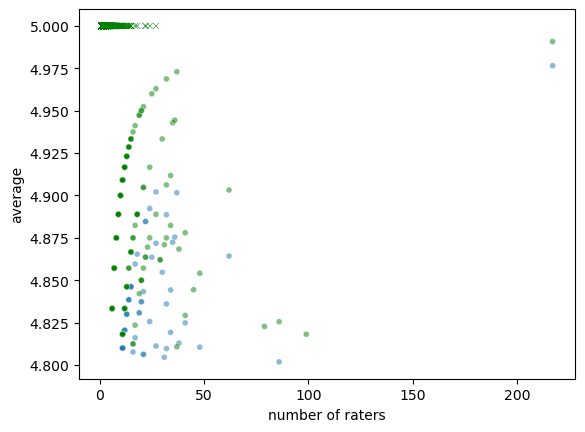

In [103]:
# calculating simple average rating per recipe 
avg_df = it.groupby(['recipe_id']).mean(['rating']).reset_index()
avg_df = pd.merge(avg_df, nb_rating_it, on='recipe_id', how='inner')
avg_df = avg_df[['recipe_id', 'number_of_raters', 'rating']]

# creating a scatter plot
sns.scatterplot(data = bayesian_avg_df.query('bayesian_avg_rating > 4.8'), x = "number_of_raters", y = "bayesian_avg_rating", alpha=0.5, size = 1, legend = False)
sns.scatterplot(data = avg_df.query('4.8 < rating < 5.0'), x = "number_of_raters", y = "rating", color = "green", alpha = 0.5, size = 1, legend = False)
ax = sns.scatterplot(data = avg_df.query('rating == 5'), x = "number_of_raters", y = "rating", color = "green", size = 1, legend = False, marker="x")
ax.set_xlabel('number of raters', fontsize=10)
ax.set_ylabel('average', fontsize=10)
plt.show()

### Further recomendations
Based on a recipe user have chosen and will choose further, the recommendation approach will be based on **Correlation**.

Each recipe in the database has the nutrition-related numeric values which we can use to find "twins" or "close relatives" of any recipe just by looking at how close the values are.

In [56]:
# splitting nutrition information by Сuisine dataframe columns (according to the author's database notation)
it[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']] = it['nutrition'].str.split(",", expand=True) 
it['calories'] = it['calories'].apply(lambda x: x.replace('[', '')) 
it['carbohydrates (PDV)'] = it['carbohydrates (PDV)'].apply(lambda x: x.replace(']', '')) 
it[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']] = it[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']].astype('float')
it.head(3)

,recipe_id,user_id,rating,name,minutes,nutrition,ingredients,tags,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
15,197160,136726,5,mexican hots,20,"[308.0, 23.0, 11.0, 20.0, 54.0, 27.0, 4.0]","['hamburger', 'breadcrumbs', 'egg', 'salt', 'b...","['30-minutes-or-less', 'time-to-make', 'course...",308.0,23.0,11.0,20.0,54.0,27.0,4.0
283,205218,269521,5,mama ortega s green chile quesadillas,20,"[100.9, 11.0, 2.0, 12.0, 11.0, 23.0, 0.0]","['cheddar cheese', 'diced green chilies', 'who...","['30-minutes-or-less', 'time-to-make', 'course...",100.9,11.0,2.0,12.0,11.0,23.0,0.0
756,232054,610843,5,layered tostada bake,40,"[698.4, 67.0, 24.0, 46.0, 69.0, 100.0, 13.0]","['ground beef', 'onion', 'taco seasoning mix',...","['60-minutes-or-less', 'time-to-make', 'course...",698.4,67.0,24.0,46.0,69.0,100.0,13.0


In [57]:
# creating Nutrition dataframe per each recipe
nutr = it.pivot_table(columns='name', values=['total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)'])
nutr

name,1 2 3 rice and chili burritos,1 minute chili cheese burritos,15 minute chicken fajitas,15 minute chili and rice wraps,15 minute no fry chicken enchiladas honest,2 texans craving salsa far from home,20 min sour cream chicken enchiladas,20 minute mexican rice,20 minute spanish rice,2009 summer salsa,...,zippy chipotle marinade for steak,zippy zonya mexi seasoning mix,zucchini hominy soup,zucchini corn black bean and jack cheese quesadillas,zucchini and corn,zucchini and sweet corn chowder,zucchini chocolate orange cake,zucchini salsa canned,zucchini torte,zucchini with cheese and green chilies
carbohydrates (PDV),15.0,7.0,6.0,15.0,20.0,14.0,13.0,15.0,17.0,4.0,...,31.0,3.0,12.0,48.0,12.0,8.0,23.0,4.0,6.0,4.0
protein (PDV),19.0,9.0,58.0,20.0,64.0,15.0,57.0,11.0,17.0,4.0,...,6.0,6.0,11.0,95.0,17.0,9.0,14.0,3.0,30.0,11.0
saturated fat (PDV),16.0,3.0,5.0,15.0,85.0,1.0,114.0,2.0,2.0,0.0,...,0.0,2.0,6.0,108.0,5.0,3.0,44.0,0.0,51.0,44.0
sodium (PDV),30.0,16.0,3.0,31.0,64.0,145.0,74.0,13.0,12.0,3.0,...,0.0,6.0,15.0,108.0,14.0,30.0,23.0,53.0,9.0,16.0
sugar (PDV),7.0,3.0,4.0,7.0,8.0,93.0,31.0,11.0,10.0,40.0,...,287.0,5.0,26.0,26.0,15.0,16.0,189.0,44.0,16.0,37.0
total fat (PDV),14.0,3.0,8.0,12.0,72.0,2.0,69.0,6.0,3.0,0.0,...,0.0,6.0,13.0,78.0,9.0,8.0,31.0,0.0,45.0,35.0


In [58]:
# creating url generating function 
def generate_url(row):
    recipe_id = it[it['name'] == row['name']]['recipe_id'].unique()
    recipe_id = recipe_id[0]
    return f"https://www.food.com/recipe/{row['name'].replace(' ', '-')}-{recipe_id}"

*Examples of recipies used in this notebook ('nogales steak tacos' and 'brown sugar bundt cake') are used so that the results of recommendation are easy to indentify as right.*

In [63]:
# choosing the recipe
recipe = 'nogales steak tacos'

# calculating top 10 recipies by nutrition correlation, generating urls
twin1 = nutr[recipe]
twin2 = nutr.corrwith(twin1)
corr = pd.DataFrame(twin2, columns=['correlation'])
corr_df = corr.sort_values('correlation', ascending=False).reset_index()
corr_df = corr_df[corr_df['name'] != recipe]            
ten_corr_df = corr_df.head(10)
ten_corr_df['url'] = ten_corr_df.apply(generate_url, axis=1)
ten_corr_df = ten_corr_df[['name', 'url', 'correlation']].drop_duplicates()
ten_corr_df['correlation'] = ten_corr_df['correlation'].round(10)
ten_corr_df = ten_corr_df[corr_df.correlation < 1]
ten_corr_df

,name,url,correlation
1,mexican monterey chicken,https://www.food.com/recipe/mexican-monterey-c...,0.999219
2,minkie s flour tortilla enchiladas,https://www.food.com/recipe/minkie-s-flour-tor...,0.996986
3,pinata tostadas,https://www.food.com/recipe/pinata-tostadas-61212,0.996697
4,easy green chile chicken bundles,https://www.food.com/recipe/easy-green-chile-c...,0.996149
5,low fat easy tasty turkey enchiladas,https://www.food.com/recipe/low-fat--easy--tas...,0.995391
6,green chile stuffed chicken breasts,https://www.food.com/recipe/green-chile-stuffe...,0.994952
7,tamale pie with cheddar cornmeal crust,https://www.food.com/recipe/tamale-pie-with-ch...,0.993312
8,easy enchilada casserole,https://www.food.com/recipe/easy-enchilada-cas...,0.993196
9,easy bisquick salsa chicken,https://www.food.com/recipe/easy-bisquick-sals...,0.992991
10,best easiest low fat chicken verde enchiladas,https://www.food.com/recipe/best--easiest---lo...,0.992989


For nogales steak tacos (green) and mexican monterey chicken (blue) (a recipe we chose and the recipe we got recommended respectively) - all nutrition PDV values visibly highly correlate. In contrast, zucchini with cheese and green chilies (red) (a random recipe) values does not correlate -> system did not recommend zucchini with cheese and green chilies. It makes sense - nogales steak tacos and mexican monterey chicken are both small protein dishes, while zucchini with cheese and green chilies is clearly a vege meal. 

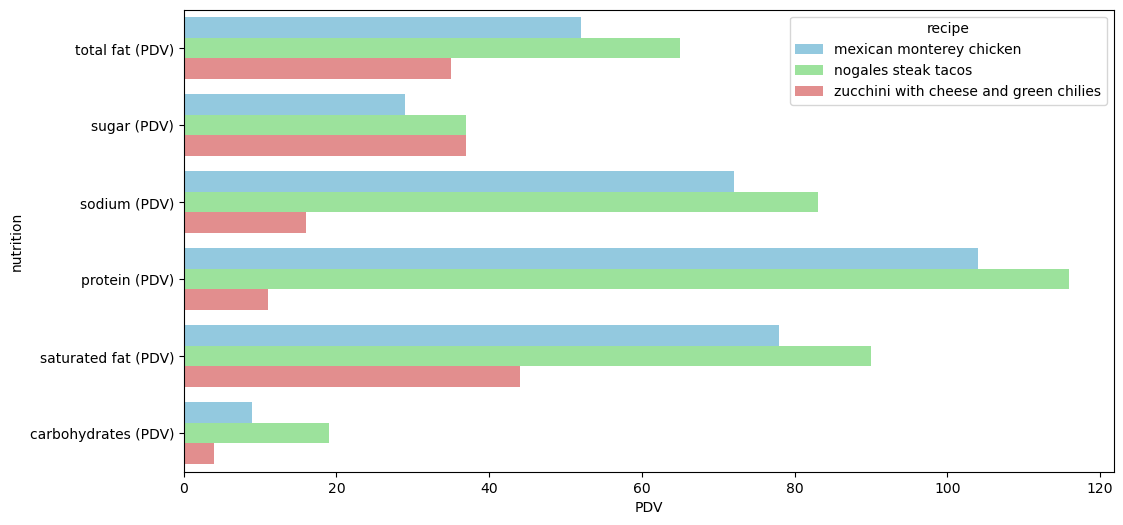

In [98]:
# selecting 
nutr_plot_df = it[['name','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']]
desired_products = ["nogales steak tacos", "mexican monterey chicken", 'zucchini with cheese and green chilies']
nutr_plot_df = nutr_plot_df[nutr_plot_df["name"].isin(desired_products)].drop_duplicates().reset_index(drop=True).set_index("name").transpose().reset_index().melt(id_vars=['index'], var_name='recipe', value_name='PDV')
nutr_plot_df['nutrition'] = nutr_plot_df['index']
nutr_plot_df = nutr_plot_df[['nutrition', 'recipe', 'PDV']]

plt.figure(figsize=(12, 6))
sns.barplot(nutr_plot_df, x="PDV", y="nutrition", hue="recipe", palette = {
    'mexican monterey chicken': 'skyblue',
    'nogales steak tacos': 'lightgreen',
    'zucchini with cheese and green chilies': 'lightcoral'
})
plt.show()

## 2. The Execution

In [6]:
# setting the unlimited column width for better visibility
pd.set_option('display.max_colwidth', None)

This part creates the class "Food" that repeats the script described in the first part. "Food" is used for easy testing and to base the GUI on.

In [7]:
inter = pd.read_csv('RAW_interactions.csv')
recip = pd.read_csv('RAW_recipes.csv')
inter = inter[['recipe_id', 'user_id', 'rating']]
recip['recipe_id'] = recip['id']
recip = recip[['recipe_id', 'name', 'minutes', 'nutrition', 'ingredients', 'tags']]
df = pd.merge(inter, recip, on='recipe_id', how='inner')

In [8]:
class Food:
    def __init__(self, df):
        self.df = df
        self.it = None
    
    def choose_cuisine(self, cuisine):
        self.it = self.df[self.df['tags'].str.contains(cuisine.replace(" ", "-"), case=False, na=False)]
        
        try:
            self.it[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']] = self.it['nutrition'].str.split(",", expand=True) 
            self.it['calories'] = self.it['calories'].apply(lambda x: x.replace('[', '')) 
            self.it['carbohydrates (PDV)'] = self.it['carbohydrates (PDV)'].apply(lambda x: x.replace(']', '')) 
            self.it[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']] = self.it[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']].astype('float')

            nb_rating_it = self.it.groupby(['recipe_id']).size().reset_index(name='number_of_raters')
            prior_weight = nb_rating_it['number_of_raters'].mean().round(0)

            avg_rating_it = self.it.groupby(['recipe_id', 'rating']).size().reset_index(name='count')
            prior_mean = self.it['rating'].mean()
            avg_rating_it['weighted_rating'] = avg_rating_it['rating'] * avg_rating_it['count']
            bayesian_avg_df = avg_rating_it.groupby('recipe_id').apply(
                lambda x: (x['weighted_rating'].sum() + (prior_mean * prior_weight)) / (x['count'].sum() + prior_weight)
            ).reset_index(name='bayesian_avg_rating').sort_values('bayesian_avg_rating', ascending=False)
            bayesian_avg_df = pd.merge(bayesian_avg_df, self.it, on='recipe_id', how='left')
            bayesian_avg_df = bayesian_avg_df[['recipe_id', 'name', 'bayesian_avg_rating']].drop_duplicates()
            bayesian_avg_df = pd.merge(bayesian_avg_df, nb_rating_it, on='recipe_id', how='left')

            bayesian_avg_df['url'] = 'https://www.food.com/recipe/' + bayesian_avg_df['name'].str.replace(" ", "-", regex=False) + '-' + bayesian_avg_df['recipe_id'].astype(str)

            bayesian_avg_df = bayesian_avg_df[['name', 'url', 'number_of_raters', 'bayesian_avg_rating']]

            return bayesian_avg_df.head(10)
        except Exception as e:
            print(f"An error occurred: {e}")
            print("Tag is not valid. Please try another one.")
            
    def generate_url(self, row):
        recipe_id = self.it[self.it['name'] == row['name']]['recipe_id'].unique()
        recipe_id = recipe_id[0]
        return f"https://www.food.com/recipe/{row['name'].replace(' ', '-')}-{recipe_id}"

    def choose_recipe(self, recipe):
        nutr = self.it.pivot_table(columns='name', values=['total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)'])
        
        try:
            twin1 = nutr[str(recipe)]
            twin2 = nutr.corrwith(twin1)
            corr = pd.DataFrame(twin2, columns=['correlation'])
            corr_df = corr.sort_values('correlation', ascending=False).reset_index()
            corr_df = corr_df[corr_df['name'] != recipe]
            
            ten_corr_df = corr_df.head(10)
            ten_corr_df['url'] = ten_corr_df.apply(self.generate_url, axis=1)
            ten_corr_df = ten_corr_df[['name', 'url', 'correlation']].drop_duplicates()
            ten_corr_df['correlation'] = ten_corr_df['correlation'].round(10)
            ten_corr_df = ten_corr_df[corr_df.correlation < 1]
            
            return ten_corr_df
        except Exception as e:
            print(f"An error occurred: {e}")
            print('Recipe is not in the database. Please try another one.')          

In [9]:
food = Food(df)

# function used for first reccomendation (top 10 recipies by Bayesian average rating)
food.choose_cuisine('dessert')

,name,url,number_of_raters,bayesian_avg_rating
0,cranberry nut swirls,https://www.food.com/recipe/cranberry-nut-swirls-94087,28,4.899987
1,chocolate covered strawberries,https://www.food.com/recipe/chocolate-covered-strawberries-58687,27,4.896861
2,greek yoghurt and fruit salad,https://www.food.com/recipe/greek-yoghurt-and-fruit-salad-166623,36,4.895111
3,chocolate chip biscuits aussie style,https://www.food.com/recipe/chocolate-chip-biscuits-aussie-style-167273,35,4.892489
4,vegan truffles,https://www.food.com/recipe/vegan-truffles-33995,35,4.892489
5,jeni s chocolate ganache,https://www.food.com/recipe/jeni-s-chocolate-ganache-97213,35,4.892489
6,brown sugar bundt cake,https://www.food.com/recipe/brown-sugar-bundt-cake-42976,118,4.891866
7,ritz cookies,https://www.food.com/recipe/ritz-cookies-48878,24,4.886192
8,colored sugar,https://www.food.com/recipe/colored-sugar-79278,31,4.880543
9,sweetslady s chocolate peanut butter brownie trifle,https://www.food.com/recipe/sweetslady-s-chocolate-peanut-butter-brownie-trifle-235380,31,4.880543


In [10]:
# function used for next reccomendations (top 10 recipies by nutrition correlation)
food.choose_recipe('brown sugar bundt cake')

,name,url,correlation
1,south carolina fresh peach cake,https://www.food.com/recipe/south-carolina-fresh-peach-cake-56296,0.999916
2,vanilla citrus tea ring,https://www.food.com/recipe/vanilla-citrus-tea-ring-58721,0.999888
3,simple oatmeal cookies,https://www.food.com/recipe/simple-oatmeal-cookies-399773,0.999840
4,carrot fruitcake,https://www.food.com/recipe/carrot-fruitcake-109472,0.999840
5,parve peach cake,https://www.food.com/recipe/parve-peach-cake-171386,0.999829
6,super moist banana pecan cake,https://www.food.com/recipe/super-moist-banana-pecan-cake-291734,0.999825
7,caramel nut brownie cookies,https://www.food.com/recipe/caramel-nut-brownie-cookies-210234,0.999804
8,blackberry wine cake,https://www.food.com/recipe/blackberry-wine-cake-46219,0.999770
9,best chocolate zucchini cake freezes well,https://www.food.com/recipe/best-chocolate-zucchini-cake--freezes-well-411697,0.999746
10,cheerwine devil s food cake,https://www.food.com/recipe/cheerwine-devil-s-food-cake-330073,0.999710
